In [4]:
from utilities import *
from preprocessing import *
lvpath = "E:\Datasets\Voice\Librivox\dev\LibriSpeech\dev-clean"
libri_train = "E:\Datasets\Voice\LibriSpeech"
mcvpath = "E:\Datasets\Voice\Mozilla Common Voice\en\cv-corpus-6.1-2020-12-11\en"
single_word = "./samples/but bowl.wav"


clips = fcs.get_audio_files(libri_train)
print(len(clips))
sr = 22000
hop_length = int(sr/200)
frame_length = int(hop_length*2.5)

C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\torchaudio\backend\utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\transformers\models\wav2vec2\tokenization_wav2vec2.py:417: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it f

In [3]:
c=182
clip = clips[c]
transcript = load_clip_transcription(clip)
phonemes =all_phones_to_array(transcript)
print(transcript ,"\n || word count: ", len(transcript.split(" ")), "|| phoneme count:", len(phonemes))
audio,sr = librosa.load(clip, sr)
hl = int(sr/200)
fl= int(hl*2)
segments = split_segments(audio, hl, fl ,sr)
print("segmented words:",len(segments))
all_bits = []
for seg in segments:
    s,e= seg[0], seg[1]
    seg_audio = audio[s:e]
    boundaries = phonme_boundaries(seg_audio,sr)
    if len(boundaries)>1:
        bits = boundaries_to_segments(boundaries)
        for b in range(len(bits)-1):
            all_bits.append(audio[s+bits[b][0]:s+bits[b][1]])

print("detected phonemes:", len(all_bits))

WOMAN SIREN THAT YOU ARE 
 || word count:  5 || phoneme count: 18
segmented words: 3
detected phonemes: 16


In [4]:
seg= segments[0]
s,e= seg[0], seg[1]
segment =audio[s:e]
hop_length = int(sr / 200)
min_duration = hop_length*10
frame_length = int(hop_length * 2.5)
mins = []
premph_seg = librosa.effects.preemphasis(segment)
sec_energy = librosa.feature.rms(
    np.abs(premph_seg), hop_length=hop_length, frame_length=frame_length)[0]

mins.extend(signal.argrelmin(sec_energy)[0] * hop_length)
#if len(mins) <2:
    #return [()]
temp_mins = [mins[0]]
means = []
for x in range(0, len(mins) - 1):
    means.append(np.mean(segment[mins[x]:mins[x + 1]]))
    # print(np.mean(segment[mins[x]:mins[x+1]]))
means = normalize(means)
for x in range(1, len(means)):
    diff = np.abs(means[x] - means[x-1])
    if diff >= 0.1 :
        temp_mins.append(mins[x])
mins = temp_mins
temp_mins =[mins[0]]
for m in range(len(mins)-1):
    if mins[m+1]-temp_mins[-1]>= min_duration:
        temp_mins.append(mins[m+1])
mins= temp_mins
#mins = np.array(mins)

In [5]:
#print(len(segment),mins ,mins[1]-mins[0])
audio , sr = librosa.load(clips[213],sr)
ipd.Audio(audio,rate=sr)

In [8]:
words_actual, words_predicted, phonemes_actual, phonemes_predicted , phonemes , Pc ,Po= [],[],[],[],[],[],[]

In [ ]:
from tqdm import tqdm
for c in tqdm(range(20000, len(clips))):
#for c in tqdm(range(15000,20000)):
     words_actual_t, words_predicted_t, phonemes_actual_t, phonemes_predicted_t , phonemes_t= auto_process(clips[c])
     words_actual.append(words_actual_t)
     words_predicted.append(words_predicted_t)
     phonemes_actual.append(phonemes_actual_t)
     phonemes_predicted.append(phonemes_predicted_t)
     phonemes.append(phonemes_t)
     Pc.append(words_predicted_t/words_actual_t)
     if phonemes_predicted_t>0:
        Po.append((phonemes_predicted_t-phonemes_actual_t)/phonemes_predicted_t)
     else:
         Po.append(0)

In [5]:
xyz = np.concatenate(phonemes[10])
aud,sr =librosa.load(clips[10],sr)
ipd.Audio(xyz, rate=sr)

In [38]:
np.save("./segmentation/words_actual.npy", words_actual)
np.save("./segmentation/words_predicted.npy", words_predicted)
np.save("./segmentation/phonemes_actual.npy", phonemes_actual)
np.save("./segmentation/phonemes_predicted.npy", phonemes_predicted)
np.save("./segmentation/phonemes.npy", phonemes)
np.save("./segmentation/Pc.npy", Pc)
np.save("./segmentation/Po.npy", Po)
# np.array([words_actual, words_predicted, phonemes_actual, phonemes_predicted , phonemes , Pc ,Po])

C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [16]:
with open("./segmentation/words_actual.npy", 'rb') as f:
    twords_actual = np.load(f, allow_pickle=True).tolist()
    words_actual.extend(twords_actual)
with open("./segmentation/words_predicted.npy", 'rb') as f:
    twords_predicted = np.load(f, allow_pickle=True).tolist()
    words_predicted.extend(twords_predicted)
with open("./segmentation/Pc.npy", 'rb') as f:
    tPc = np.load(f, allow_pickle=True).tolist()
    Pc.extend(tPc)
with open("./segmentation/phonemes_actual.npy", 'rb') as f:
    tphonemes_actual = np.load(f, allow_pickle=True).tolist()
    phonemes_actual.extend(tphonemes_actual)
with open("./segmentation/phonemes_predicted.npy", 'rb') as f:
    tphonemes_predicted = np.load(f, allow_pickle=True).tolist()
    phonemes_predicted.extend(tphonemes_predicted)
with open("./segmentation/Po.npy", 'rb') as f:
    tPo = np.load(f, allow_pickle=True).tolist()
    Po.extend(tPo)
len(phonemes_predicted),len(phonemes_actual) ,len(words_predicted), len(words_actual)

(28539, 28539, 28539, 28539)

In [23]:
#np.average(Pc), np.average(Po)
percent_correct_phonemes, percent_correct_words, percent_undersegmentation_words, percent_undersegmentation_phonemes = [],[],[],[]
for c in range(len(phonemes_predicted)):
    if phonemes_predicted[c]>0:
        percent_correct_phonemes.append(phonemes_predicted[c]/phonemes_actual[c])
        percent_correct_words.append(words_predicted[c]/words_actual[c])
        percent_undersegmentation_words = (words_predicted[c]-words_actual[c])/words_predicted[c]
        percent_undersegmentation_phonemes = (phonemes_predicted[c]-phonemes_actual[c])/phonemes_predicted[c]

In [24]:
np.average(percent_correct_phonemes), np.average(percent_correct_words), np.average(percent_undersegmentation_words), np.average(percent_undersegmentation_phonemes)

(0.6591892484395989,
 0.7604824282875106,
 -0.7142857142857143,
 -0.39285714285714285)

In [22]:
np.average(Pc)*100 , np.average(Po)*100

(76.04391453914434, -66.99508355625012)

In [14]:
Pc100 =  np.array(Pc)*100
Pc100
Po100 = np.array(Po)*100

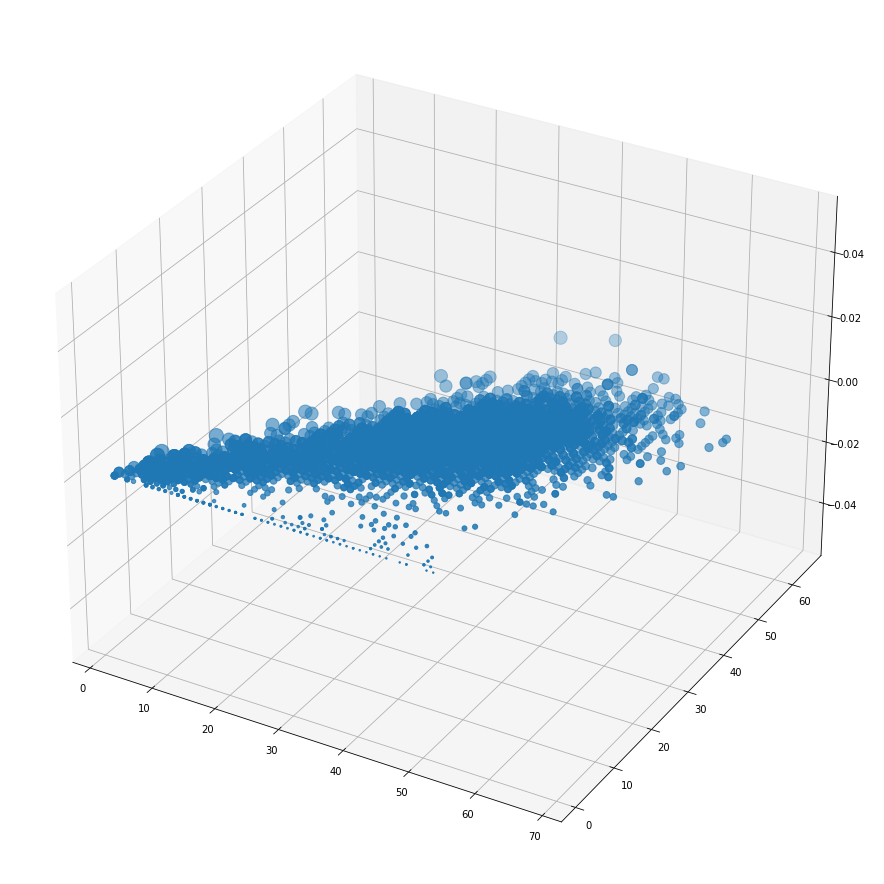

In [15]:
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(projection='3d')
plt.scatter(words_actual,words_predicted,Pc100)
plt.show()

In [2]:
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(projection='3d')
ax.scatter(phonemes_actual,phonemes_predicted,Po100)
ax.set_xlabel("actual count")
ax.set_ylabel("predicted count")
ax.set_zlabel("over Segmentation")
plt.show()

NameError: name 'plt' is not defined

In [1]:
len(phonemes_actual), len(words_actual), len(words_predicted) , len(phonemes_predicted) , sum(phonemes_predicted)
#phonemes_actual[1:10], phonemes_predicted[1:10], Po100

NameError: name 'phonemes_actual' is not defined

In [ ]:
results = np.array([words_actual,words_predicted,phonemes_actual,phonemes_predicted])

In [12]:
#np.argmax(words_actual)
words_actual[np.argmax(words_actual)]
bins = np.linspace(0,70,8)
digi= np.digitize(words_actual,bins)
#np.where(digi ==1)

(63,)
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\nerdi\.conda\envs\pyAudio\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-13-6dcf252cc0e6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(legends)


Text(0, 0.5, 'Percentage Correct Predicted word count')

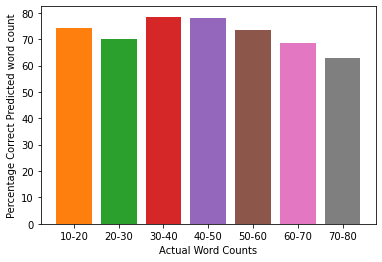

In [13]:
print(np.array(words_predicted)[np.where(digi ==7)].shape)
legends = []
fig, ax = plt.subplots()
for x in range(0,8):
    #plt.bar(x*1.5,np.average(np.array(words_actual)[np.where(digi ==x)]),1 ,alpha=0.5 )
    #plt.bar(x*1.5,np.average(np.array(words_predicted)[np.where(digi ==x)]),1 ,alpha=0.5, color='k')
    label = str(x*10)+'-'+str((x+1)*10)
    ax.bar(x,  np.average(np.array(Pc)[np.where(digi ==x)])*100, label=label )
    legends.append(label)
ax.set_xticklabels(legends)
plt.xlabel("Actual Word Counts")
plt.ylabel("Percentage Correct Predicted word count")



(63,)
<ipython-input-14-03194db4a684>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(legends)


Text(0, 0.5, 'Percentage Under Segmentation')

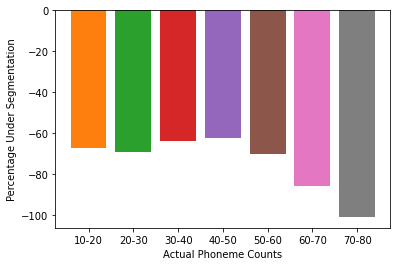

In [14]:
print(np.array(words_predicted)[np.where(digi ==7)].shape)
legends = []
fig, ax = plt.subplots()
for x in range(0,8):
    #plt.bar(x*1.5,np.average(np.array(words_actual)[np.where(digi ==x)]),1 ,alpha=0.5 )
    #plt.bar(x*1.5,np.average(np.array(words_predicted)[np.where(digi ==x)]),1 ,alpha=0.5, color='k')
    label = str(x*10)+'-'+str((x+1)*10)
    ax.bar(x,  np.average(np.array(Po)[np.where(digi ==x)])*100, label=label )
    legends.append(label)
ax.set_xticklabels(legends)
plt.xlabel("Actual Phoneme Counts")
plt.ylabel("Percentage Under Segmentation")


In [ ]:
legends = []
fig, ax = plt.subplots()
for x in range(0,8):
    #plt.bar(x*1.5,np.average(np.array(words_actual)[np.where(digi ==x)]),1 ,alpha=0.5 )
    #plt.bar(x*1.5,np.average(np.array(words_predicted)[np.where(digi ==x)]),1 ,alpha=0.5, color='k')
    label = str(x*10)+'-'+str((x+1)*10)
    ax.bar(x,  np.average(np.array(Pc)[np.where(digi ==x)])*100, label=label )
    legends.append(label)
ax.set_xticklabels(legends)
plt.xlabel("Actual Word Counts")
plt.ylabel("Percentage Correct Predicted word count")

In [ ]:
print(np.array(words_predicted)[np.where(digi ==7)].shape)
legends = []
fig, ax = plt.subplots()
for x in range(0,8):
    #plt.bar(x*1.5,np.average(np.array(words_actual)[np.where(digi ==x)]),1 ,alpha=0.5 )
    #plt.bar(x*1.5,np.average(np.array(words_predicted)[np.where(digi ==x)]),1 ,alpha=0.5, color='k')
    label = str(x*10)+'-'+str((x+1)*10)
    ax.bar(x,  np.average(np.array(Po)[np.where(digi ==x)])*100, label=label )
    legends.append(label)
ax.set_xticklabels(legends)
plt.xlabel("Actual Phoneme Counts")
plt.ylabel("Percentage Under Segmentation")

In [25]:
np.sum(phonemes_actual) , np.sum(words_actual), len(words_actual), np.sum(phonemes_predicted), np.sum(words_predicted)

(3383341, 990101, 28539, 2192413, 747618)